__Setting up any modules we will need__

In [1]:
# Importing any models we might need
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import imblearn
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import SGDClassifier

__Loading the full prepared dataset and adding a categorical variable on the target.__

In [2]:
df = pd.read_csv('final_total_cleaned_with_missing.csv')
df.columns

Index(['housenum', 'postcode', 'Buurt2019', 'oppervlakte', 'bouwjaar',
       'WONING_TYPE', 'bev_dich', 'g_woz', 'p_1gezw', 'p_mgezw', 'p_koopw',
       'p_huurw', 'p_wcorpw', 'p_ov_hw', 'g_ele', 'g_gas', 'p_stadsv',
       'p_hh_lkk_y', 'p_hh_osm_y', 'a_inw_s', 'a_man_s', 'a_vrouw_s',
       'a_00_14_s', 'a_15_24_s', 'a_25_44_s', 'a_45_64_s', 'a_65_oo_s',
       'a_hh_s', 'a_1p_hh_s', 'a_hh_z_k_s', 'a_soz_ao_s', 'a_soz_ww_s',
       'AantalInstallatiesBijWoningen_5_s', 'LABEL'],
      dtype='object')

In [3]:
#remove some infinite values
df = df.replace([np.inf, -np.inf], np.nan)
#given the very low frequencies observed for labels A+, A++, we decide to map these to "A"
df = df.replace(['A+', 'A++'], 'A')

#transforming the categorical variable "Woning Type"
df = pd.get_dummies(df, columns=['WONING_TYPE'])

#creating feature matrix X, labels y and binned labels y_cat
X = df.drop([ 'housenum', 
       'postcode', 'Buurt2019', 'LABEL'], axis=1)

df['LABEL_CAT'] = df['LABEL'].replace('A','High')
df['LABEL_CAT'] = df['LABEL_CAT'].replace('B','High')
df['LABEL_CAT'] = df['LABEL_CAT'].replace('C','Medium')
df['LABEL_CAT'] = df['LABEL_CAT'].replace('D','Medium')
df['LABEL_CAT'] = df['LABEL_CAT'].replace('E','Low')
df['LABEL_CAT'] = df['LABEL_CAT'].replace('F','Low')
df['LABEL_CAT'] = df['LABEL_CAT'].replace('G','Low')

y = df['LABEL']
y_cat = df['LABEL_CAT']

Both the non-binned as the binned labels show imbalance in their distribution

In [4]:
y.value_counts(normalize=True)

C    0.291674
A    0.243183
B    0.173386
D    0.135617
E    0.074443
F    0.045203
G    0.036492
Name: LABEL, dtype: float64

In [5]:
y_cat.value_counts(normalize=True)

Medium    0.427292
High      0.416570
Low       0.156138
Name: LABEL_CAT, dtype: float64

# Outlier detection through boxplots

In [6]:
X.columns

# WONING_TYPE_* columns are dummified categorical features, no outliers there.

Index(['oppervlakte', 'bouwjaar', 'bev_dich', 'g_woz', 'p_1gezw', 'p_mgezw',
       'p_koopw', 'p_huurw', 'p_wcorpw', 'p_ov_hw', 'g_ele', 'g_gas',
       'p_stadsv', 'p_hh_lkk_y', 'p_hh_osm_y', 'a_inw_s', 'a_man_s',
       'a_vrouw_s', 'a_00_14_s', 'a_15_24_s', 'a_25_44_s', 'a_45_64_s',
       'a_65_oo_s', 'a_hh_s', 'a_1p_hh_s', 'a_hh_z_k_s', 'a_soz_ao_s',
       'a_soz_ww_s', 'AantalInstallatiesBijWoningen_5_s',
       'WONING_TYPE_Flatwoning (overig)', 'WONING_TYPE_Galerijwoning',
       'WONING_TYPE_Maisonnette', 'WONING_TYPE_Portiekwoning',
       'WONING_TYPE_Rijwoning tussen',
       'WONING_TYPE_Twee-onder-een-kap / rijwoning hoek',
       'WONING_TYPE_Vrijstaande woning',
       'WONING_TYPE_Woongebouw met niet-zelfstandige woonruimte'],
      dtype='object')

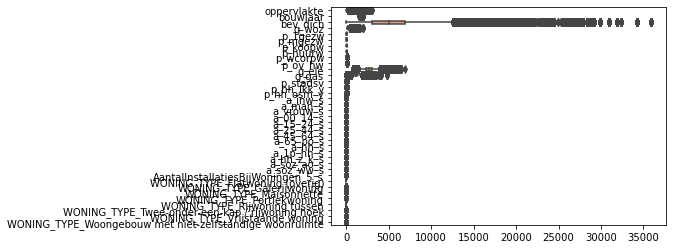

In [7]:
sns.boxplot(data=X,width=0.5, orient='h')

__Very first rough view shows outliers in the 1st, 2nd, 3rd, 4th, 11th, 12th, 13th, 14th columns__

Those columns are:
'oppervlakte', 'bouwjaar', 'bev_dich', 'g_woz' p_bjj2k p_bjo2k g_ele g_gas p_stadsv

count    406364.000000
mean        106.196449
std          83.983846
min          11.000000
25%          73.000000
50%          95.000000
75%         119.000000
max        2997.000000
Name: oppervlakte, dtype: float64


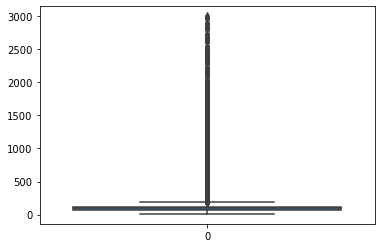

In [8]:
#in the data cleaning phase, we  made sure that no weird values for "oppervlak" arise in our dataframe

sns.boxplot(data=X['oppervlakte'])

print(X['oppervlakte'].describe())

count    406364.000000
mean       1975.697552
std          27.818018
min        1514.000000
25%        1964.000000
50%        1978.000000
75%        1994.000000
max        2020.000000
Name: bouwjaar, dtype: float64
(1969.4, 2020.0]      265740
(1918.8, 1969.4]      125958
(1868.2, 1918.8]       13304
(1817.6, 1868.2]         681
(1767.0, 1817.6]         270
(1716.4, 1767.0]         207
(1615.2, 1665.8]          85
(1665.8, 1716.4]          84
(1564.6, 1615.2]          28
(1513.493, 1564.6]         7
Name: bouwjaar, dtype: int64


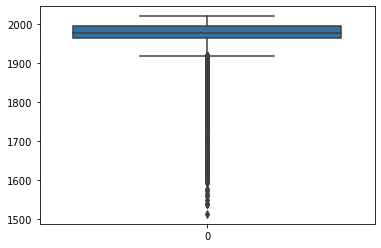

In [9]:
# double checking that we don't have odd values in the bouwjaar variable (i.e. buildings build in the future or before 1500)
sns.boxplot(data=X['bouwjaar'])

print(X['bouwjaar'].describe())
print(X['bouwjaar'].value_counts(bins=10))



count    406364.000000
mean       5531.961675
std        3982.021558
min           1.000000
25%        3084.000000
50%        4974.000000
75%        6895.000000
max       35855.000000
Name: bev_dich, dtype: float64
(3586.4, 7171.8]      180845
(-34.855, 3586.4]     131162
(7171.8, 10757.2]      64737
(10757.2, 14342.6]     16305
(14342.6, 17928.0]      5911
(21513.4, 25098.8]      2566
(17928.0, 21513.4]      2318
(25098.8, 28684.2]      1880
(28684.2, 32269.6]       543
(32269.6, 35855.0]        97
Name: bev_dich, dtype: int64


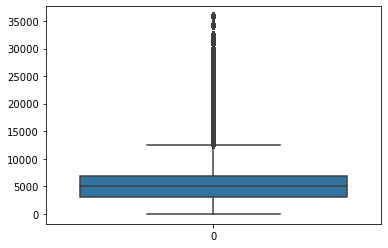

In [10]:
sns.boxplot(data=X['bev_dich'])

print(X['bev_dich'].describe())
print(X['bev_dich'].value_counts(bins=10))

# Due to the implementation of the binning it looks like there are negative values, but there are no actual negative values in the bin which starts at -34. Values vary, but all look reasonable enough.


count    402721.000000
mean        237.427033
std          94.682832
min          46.000000
25%         174.000000
50%         222.000000
75%         276.000000
max        1985.000000
Name: g_woz, dtype: float64
(44.06, 239.9]      234761
(239.9, 433.8]      153913
(433.8, 627.7]       11679
(627.7, 821.6]        1538
(821.6, 1015.5]        512
(1015.5, 1209.4]       206
(1209.4, 1403.3]        92
(1403.3, 1597.2]        12
(1791.1, 1985.0]         5
(1597.2, 1791.1]         3
Name: g_woz, dtype: int64


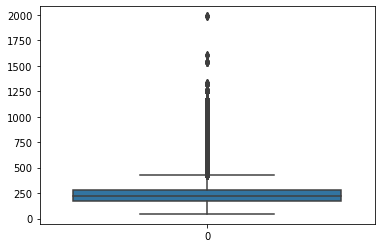

In [11]:
sns.boxplot(data=X['g_woz'])

print(X['g_woz'].describe())
print(X['g_woz'].value_counts(bins=10))

# It looks fortunate and unfortunate for some areas, but values seem within reasonable bounds for average house valuation

In [12]:
# We will remove p_bjj2k and p_bjo2k so no sense in detecting outliers.

electricity usage
count    406127.000000
mean       2706.455690
std         537.670016
min         810.000000
25%        2360.000000
50%        2680.000000
75%        2980.000000
max        6920.000000
Name: g_ele, dtype: float64
(2643.0, 3254.0]     167952
(2032.0, 2643.0]     157556
(3254.0, 3865.0]      35880
(1421.0, 2032.0]      32543
(3865.0, 4476.0]       6334
(4476.0, 5087.0]       4438
(5087.0, 5698.0]        892
(803.889, 1421.0]       399
(5698.0, 6309.0]         82
(6309.0, 6920.0]         51
Name: g_ele, dtype: int64


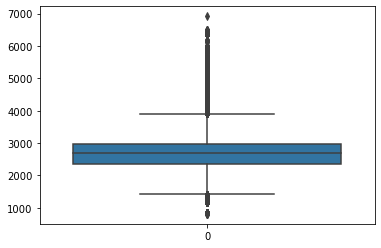

In [13]:
#g_ele g_gas p_stadsv
print( "electricity usage")
sns.boxplot(data=X['g_ele'])

print(X['g_ele'].describe())
print(X['g_ele'].value_counts(bins=10))

# Some massive users, but within reasonable expectations.

gas usage
count    394394.000000
mean       1166.145048
std         328.069849
min          10.000000
25%        1000.000000
50%        1150.000000
75%        1320.000000
max        4780.000000
Name: g_gas, dtype: float64
(964.0, 1441.0]     255548
(487.0, 964.0]       75145
(1441.0, 1918.0]     43518
(5.229, 487.0]        9708
(1918.0, 2395.0]      8343
(2395.0, 2872.0]      1697
(2872.0, 3349.0]       357
(3349.0, 3826.0]        54
(3826.0, 4303.0]        18
(4303.0, 4780.0]         6
Name: g_gas, dtype: int64


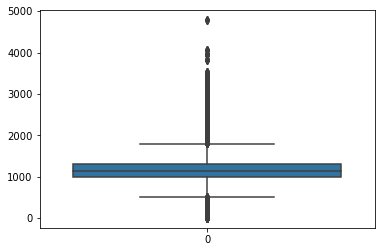

In [14]:
print( "gas usage")
sns.boxplot(data=X['g_gas'])

print(X['g_gas'].describe())
print(X['g_gas'].value_counts(bins=10))

# Some massive users, but within reasonable expectations.

city heating
count    406364.000000
mean          5.220599
std          19.049158
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: p_stadsv, dtype: float64
(-0.101, 10.0]    370251
(90.0, 100.0]      12089
(10.0, 20.0]        7231
(30.0, 40.0]        4101
(20.0, 30.0]        3724
(40.0, 50.0]        2278
(50.0, 60.0]        2160
(60.0, 70.0]        2098
(80.0, 90.0]        1339
(70.0, 80.0]        1093
Name: p_stadsv, dtype: int64


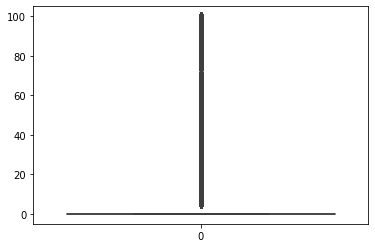

In [15]:
print( "city heating")
sns.boxplot(data=X['p_stadsv'])

print(X['p_stadsv'].describe())
print(X['p_stadsv'].value_counts(bins=10))

# Values in bounds, just not so many houses connected to city heating in the Netherlands

# Random undersampling and train_test_split
__Random Undersampling to make training and iterating feasible on our machines__

Due to capacity constraints, we take 5% of the full data set after which we apply undersampling to make sure that the labels we are predicting are balanced.

In [16]:
sample_used = 0.05
rus = RandomUnderSampler(replacement=False, random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_rus, y_rus, random_state=42, train_size=sample_used*0.75, test_size = sample_used*0.25)

In [17]:
y_train.value_counts(normalize=True)

C    0.149538
A    0.145940
D    0.145683
E    0.143371
B    0.141572
F    0.137205
G    0.136691
Name: LABEL, dtype: float64

Our sampling approach resulted in a more uniform distribution over the different labels. And a more manageable training test size.

In [18]:
X_train.shape

(3892, 37)

# Imputation of missing values
__We impute missing values using K Nearest Neighbour imputation__

In [19]:
#using a simple KNN imputer here to impute missing values
imputer = KNNImputer()

# First Model - Random Forest

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.38771875 0.42137966 0.42317684 0.41547069 0.41983724
 0.42035039]
  warnings.warn(
C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 0.48561177 0.77222461 0.94636355 0.97790324 0.97983041
 0.97989464]
  warnings.warn(


0.9244604316546763
best mean cross-validation score: 0.423
Best max_depth: 15


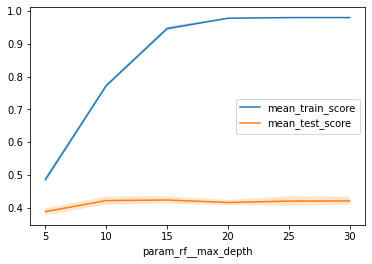

In [20]:
rf = RandomForestClassifier(warm_start=True, random_state=42)


pipe =  Pipeline(steps=[('imp', imputer),  ('rf', rf)])
param_grid = {'rf__max_depth': [0,5,10,15,20,25,30]}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_depth:', grid.best_estimator_.get_params()['rf__max_depth'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_rf__max_depth', 'mean_train_score')
results.plot('param_rf__max_depth', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_rf__max_depth.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_rf__max_depth.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

Bad performance on non-binned labels leads us to conclude that we will try to predict energy labels that are either High/Medium/Low.

In [21]:
#train test split with categories high medium low ('y_cat')
sample_used = 0.05
rus = RandomUnderSampler(replacement=False, random_state =42)
X_rus, y_rus = rus.fit_resample(X, y_cat)
X_train, X_test, y_train, y_test = train_test_split(
    X_rus, y_rus, random_state=42, train_size=sample_used*0.75, test_size = sample_used*0.25)

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.66713345 0.69557199 0.6994967  0.68968934 0.68856791]
  warnings.warn(
C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 0.68517089 0.80029425 0.93566147 0.98234803 0.98634072]
  warnings.warn(


0.9173437937797703
best mean cross-validation score: 0.699
Best max_depth: 15


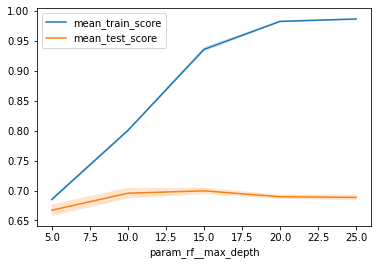

In [22]:
#rf with max_depth param

rf = RandomForestClassifier(warm_start=True, random_state=42)

pipe =  Pipeline(steps=[('imp', imputer),  ('rf', rf)])
param_grid = {'rf__max_depth': [0,5,10,15,20,25]}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_depth:', grid.best_estimator_.get_params()['rf__max_depth'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_rf__max_depth', 'mean_train_score')
results.plot('param_rf__max_depth', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_rf__max_depth.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_rf__max_depth.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

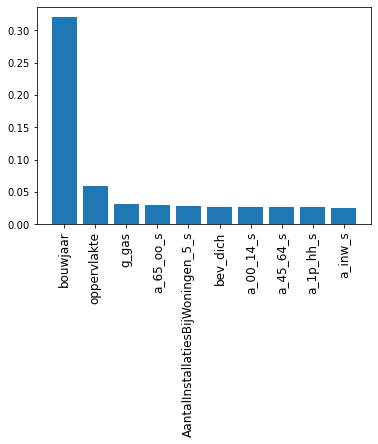

In [23]:
#features that we gathered on object level (bouwjaar/oppervlakte) - seem to be highly important in predicting the energy label.
feature_imp = grid.best_estimator_.named_steps['rf'].feature_importances_
df2 = pd.DataFrame(feature_imp,X_train.columns,["feature_importance"])
df2 = df2.sort_values(by="feature_importance" , ascending=False)
df2 = df2[:10]
plt.bar(df2.index, df2.feature_importance, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.show()

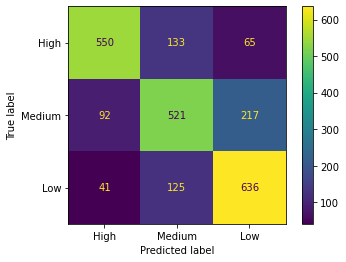

In [24]:
plot_confusion_matrix(grid, X_test, y_test, labels=["High","Medium", "Low"])

In [25]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

        High       0.81      0.74      0.77       748
         Low       0.69      0.79      0.74       802
      Medium       0.67      0.63      0.65       830

    accuracy                           0.72      2380
   macro avg       0.72      0.72      0.72      2380
weighted avg       0.72      0.72      0.72      2380



0.9840291398150742
best mean cross-validation score: 0.689
Best n_estimator: 46


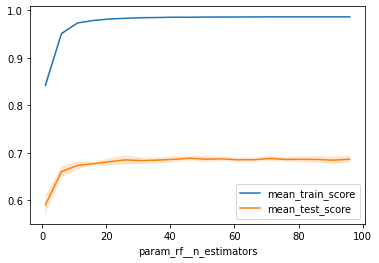

In [26]:
#rf with n_estimators param
pipe =  Pipeline(steps=[('imp', imputer), ('rf', rf)])
param_grid = {'rf__n_estimators': range(1, 100, 5)}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best n_estimator:', grid.best_estimator_.get_params()['rf__n_estimators'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_rf__n_estimators', 'mean_train_score')
results.plot('param_rf__n_estimators', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_rf__n_estimators.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_rf__n_estimators.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

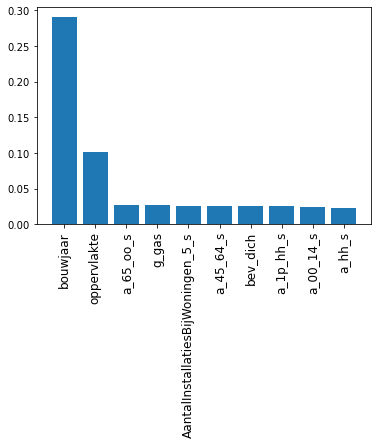

In [27]:
feature_imp = grid.best_estimator_.named_steps['rf'].feature_importances_
df2 = pd.DataFrame(feature_imp,X_train.columns,["feature_importance"])
df2 = df2.sort_values(by="feature_importance" , ascending=False)
df2 = df2[:10]
plt.bar(df2.index, df2.feature_importance, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.show()

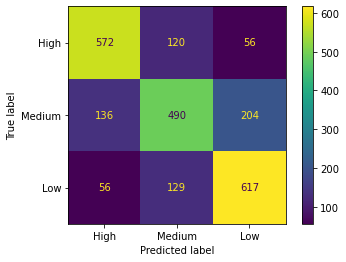

In [28]:
plot_confusion_matrix(grid, X_test, y_test, labels=["High","Medium", "Low"])

In [29]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

        High       0.75      0.76      0.76       748
         Low       0.70      0.77      0.73       802
      Medium       0.66      0.59      0.62       830

    accuracy                           0.71      2380
   macro avg       0.71      0.71      0.71      2380
weighted avg       0.70      0.71      0.70      2380



0.808209582516111
best mean cross-validation score: 0.698
Best min_samples: 35


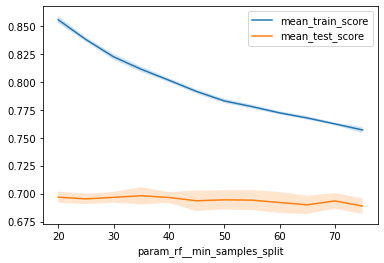

In [30]:
#rf with min_samples_split param
pipe =  Pipeline(steps=[('imp', imputer), ('rf', rf)])
param_grid = {'rf__min_samples_split': range(20, 80, 5)}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best min_samples:', grid.best_estimator_.get_params()['rf__min_samples_split'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_rf__min_samples_split', 'mean_train_score')
results.plot('param_rf__min_samples_split', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_rf__min_samples_split.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_rf__min_samples_split.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

The plot above looks slightly different than the other two RF parameters plotted. Increasing min_samples actually results in the tree being less complex.

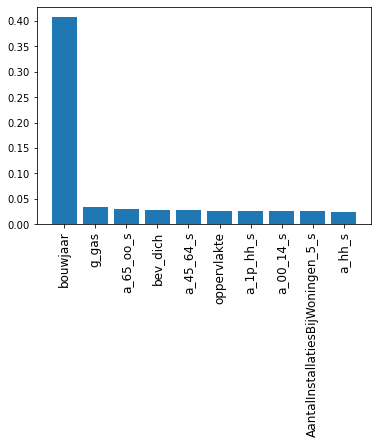

In [31]:
feature_imp = grid.best_estimator_.named_steps['rf'].feature_importances_
df2 = pd.DataFrame(feature_imp,X_train.columns,["feature_importance"])
df2 = df2.sort_values(by="feature_importance" , ascending=False)
df2 = df2[:10]
plt.bar(df2.index, df2.feature_importance, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.show()


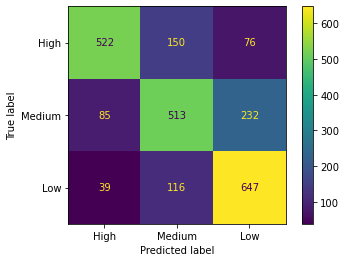

In [32]:
plot_confusion_matrix(grid, X_test, y_test, labels=["High","Medium", "Low"])


In [33]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

        High       0.81      0.70      0.75       748
         Low       0.68      0.81      0.74       802
      Medium       0.66      0.62      0.64       830

    accuracy                           0.71      2380
   macro avg       0.71      0.71      0.71      2380
weighted avg       0.71      0.71      0.71      2380



# Second Model - LogisticRegression

In [34]:
# We use y_cat also for LogReg, performance on y is very poor.
sample_used = 0.05
rus = RandomUnderSampler(replacement=False, random_state =42)
X_rus, y_rus = rus.fit_resample(X, y_cat)
X_train, X_test, y_train, y_test = train_test_split(
    X_rus, y_rus, random_state=42, train_size=sample_used*0.75, test_size = sample_used*0.25)

# Dummies make the model less performant, so deciding not to use WONING_TYPE at all.
#X_train = X_train.drop(['WONING_TYPE'], axis=1)
#X_test = X_test.drop(['WONING_TYPE'], axis=1)

#Impute
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.fit_transform(X_test)

# Now let's do LogReg again, but on a normalized set
#X_train_norm = sklearn.preprocessing.normalize(X_train_imp)
#X_test_norm = sklearn.preprocessing.normalize(X_test_imp)

#standardized performs way better than normalize ~.2 difference
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train_imp)

X_train_st = scaler.transform(X_train_imp)
X_test_st = scaler.transform(X_test_imp)

C:\Users\simon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGREG train on train:  0.63897450266181 test on test:  0.6369747899159663


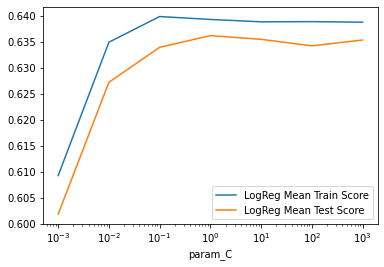

In [35]:
logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs")
param_grid = {"C":np.logspace(-3,3,7)}


grid = GridSearchCV(logreg, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train_st,y_train)

print("LOGREG train on train: ", grid.score(X_train_st,y_train), "test on test: ", grid.score(X_test_st,y_test))

# Visualize the impact of tweaking C, although the highest score on test was achieved with the default 1-setting.

results_grid = pd.DataFrame(grid.cv_results_)

results_grid.plot('param_C', 'mean_train_score', label="LogReg Mean Train Score", ax=plt.gca())
results_grid.plot('param_C', 'mean_test_score', label="LogReg Mean Test Score", ax=plt.gca())
plt.legend()
plt.xscale("log")

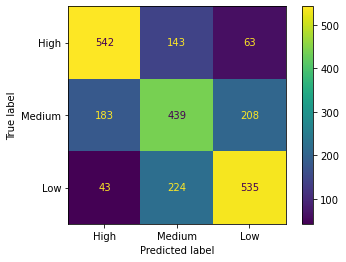

In [36]:
plot_confusion_matrix(grid, X_test_st, y_test, labels=["High","Medium", "Low"])

Text(0.5, 1.0, "('Feature Importance for target value ', 'High')")

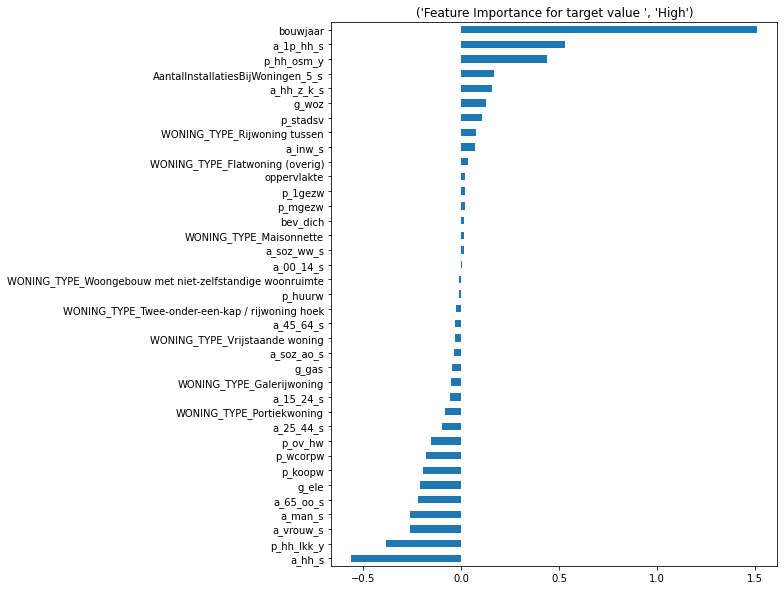

In [37]:
titeltje = "Feature Importance for target value ", grid.best_estimator_.classes_[0]

coef = pd.Series(grid.best_estimator_.coef_[0], index = X.columns)
imp_coef = coef.sort_values()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(titeltje)

Text(0.5, 1.0, "('Feature Importance for target value ', 'Low')")

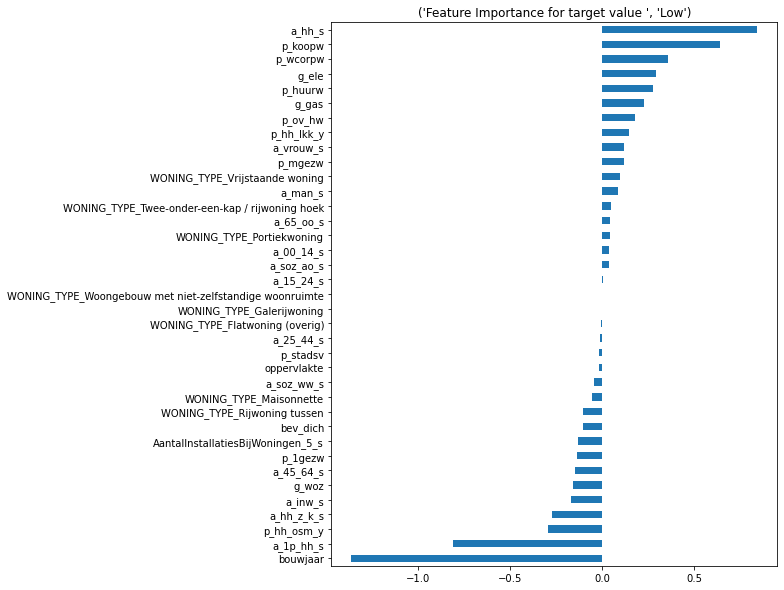

In [38]:
titeltje = "Feature Importance for target value ", grid.best_estimator_.classes_[1]

coef = pd.Series(grid.best_estimator_.coef_[1], index = X.columns)
imp_coef = coef.sort_values()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(titeltje)

Text(0.5, 1.0, "('Feature Importance for target value ', 'Medium')")

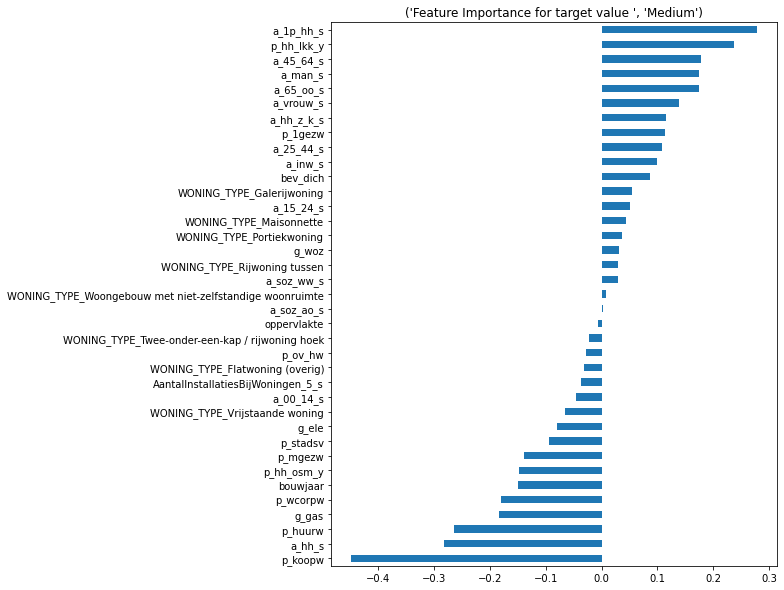

In [39]:
titeltje = "Feature Importance for target value ", grid.best_estimator_.classes_[2]

coef = pd.Series(grid.best_estimator_.coef_[2], index = X.columns)
imp_coef = coef.sort_values()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(titeltje)

# Model 3 eXtreme Gradient Boosting Classifier

Train XGBoost Classifier, first see what impact the different parameters have:

Learning rate

max depth

Gamma

N_estimators

then train one with optimization on four parameters

In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
pipe =  Pipeline(steps=[('imp', imputer), ('xgb', xgb)])
param_grid = { 'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best learning_rate:', grid.best_estimator_.get_params()['xgb__learning_rate'])

C:\Users\simon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8437937797702437
best mean cross-validation score: 0.701
Best learning_rate: 0.1


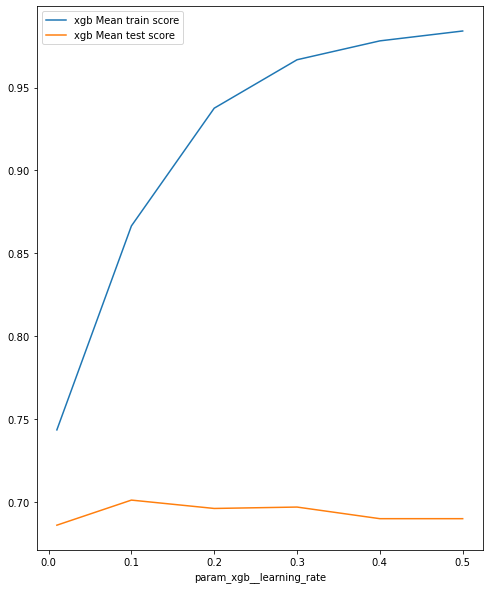

In [41]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_xgb__learning_rate', 'mean_train_score', label='xgb Mean train score')
results.plot('param_xgb__learning_rate', 'mean_test_score', ax=plt.gca(), label='xgb Mean test score')
plt.legend()

In [42]:
xgb = XGBClassifier()
pipe =  Pipeline(steps=[('imp', imputer), ('xgb', xgb)])
param_grid = { 'xgb__max_depth': range(3 , 10)}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_depth:', grid.best_estimator_.get_params()['xgb__max_depth'])

C:\Users\simon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9047352199495657
best mean cross-validation score: 0.699
Best max_depth: 5


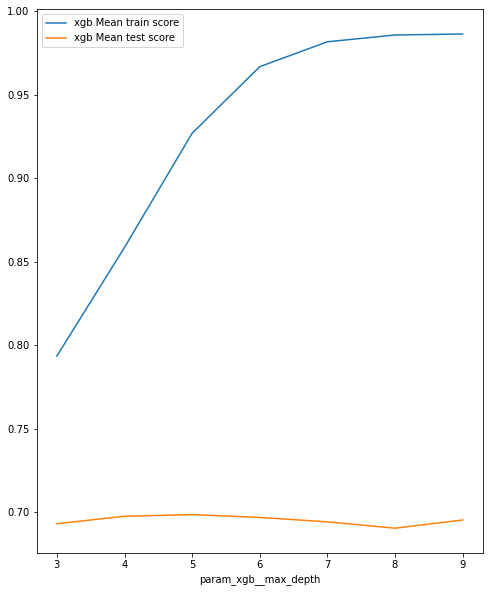

In [43]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_xgb__max_depth', 'mean_train_score', label='xgb Mean train score')
results.plot('param_xgb__max_depth', 'mean_test_score', ax=plt.gca(), label='xgb Mean test score')
plt.legend()

In [44]:
xgb = XGBClassifier()
pipe =  Pipeline(steps=[('imp', imputer), ('xgb', xgb)])
param_grid = { 'xgb__gamma': [i/10.0 for i in range(8)]}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best gamma:', grid.best_estimator_.get_params()['xgb__gamma'])

C:\Users\simon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9588119921546652
best mean cross-validation score: 0.697
Best gamma: 0.0


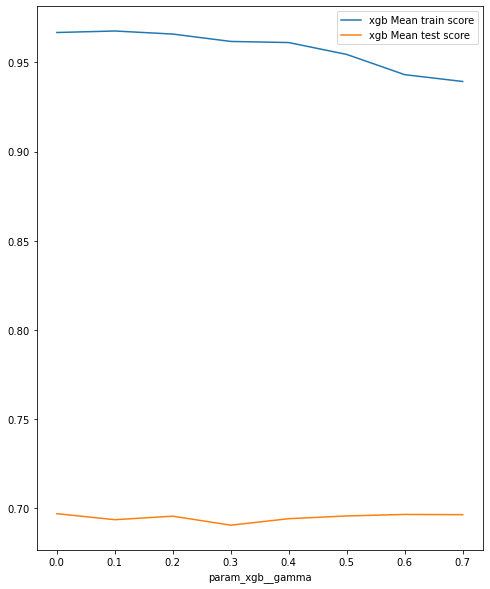

In [45]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_xgb__gamma', 'mean_train_score', label='xgb Mean train score')
results.plot('param_xgb__gamma', 'mean_test_score', ax=plt.gca(), label='xgb Mean test score')
plt.legend()

In [46]:
xgb = XGBClassifier()
pipe =  Pipeline(steps=[('imp', imputer), ('xgb', xgb)])
param_grid = { 'xgb__n_estimators': [100,200,300, 400, 500]}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best n_estimators:', grid.best_estimator_.get_params()['xgb__n_estimators'])

C:\Users\simon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9588119921546652
best mean cross-validation score: 0.697
Best n_estimators: 100


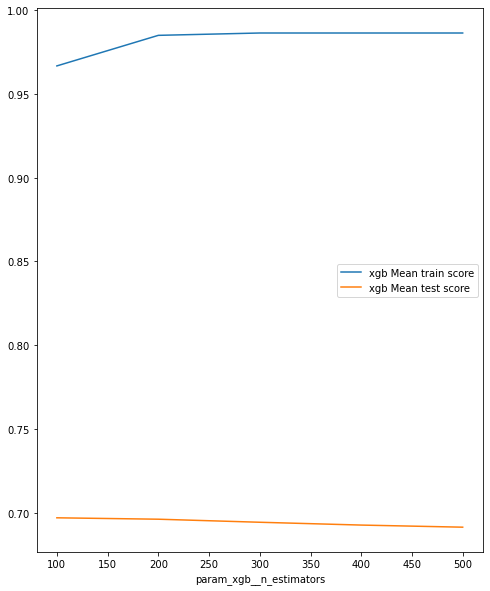

In [47]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_xgb__n_estimators', 'mean_train_score', label='xgb Mean train score')
results.plot('param_xgb__n_estimators', 'mean_test_score', ax=plt.gca(), label='xgb Mean test score')
plt.legend()

Trained with combination of best estimators. However max tree is set to 100 or 200, because of training time. 

In [48]:
xgb = XGBClassifier()
pipe =  Pipeline(steps=[('imp', imputer), ('xgb', xgb)])
param_grid = {'xgb__max_depth': range(4 , 9), 'xgb__learning_rate': [0.1, 0.2, 0.3], 'xgb__gamma': [0.0, 0.1, 0.3, 0.5], 'xgb__n_estimators': [100,200]}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_depth:', grid.best_estimator_.get_params()['xgb__max_depth'])
print('Best learning_rate:', grid.best_estimator_.get_params()['xgb__learning_rate'])
print('Best gamma:', grid.best_estimator_.get_params()['xgb__gamma'])
print('Best n_estimators:', grid.best_estimator_.get_params()['xgb__n_estimators'])

C:\Users\simon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9299523676099748
best mean cross-validation score: 0.705
Best max_depth: 8
Best learning_rate: 0.1
Best gamma: 0.0
Best n_estimators: 100


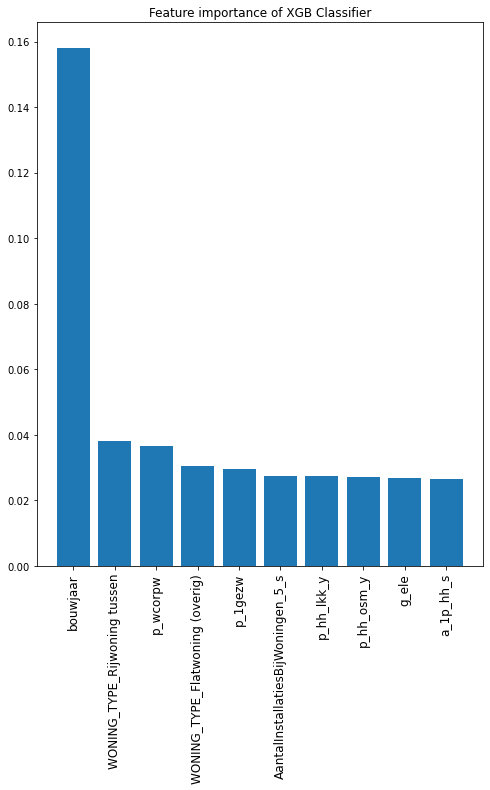

In [49]:
#plot the most important features
feature_imp = grid.best_estimator_.named_steps['xgb'].feature_importances_
df_feature = pd.DataFrame(feature_imp,X_train.columns,["feature_importance"])
df_feature = df_feature.sort_values(by="feature_importance" , ascending=False)
df_feature = df_feature[:10]
plt.bar(df_feature.index, df_feature.feature_importance, orientation = 'vertical')
plt.tick_params( axis="x", labelsize=12, labelrotation=90)
plt.title('Feature importance of XGB Classifier')
plt.show()

In [50]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, grid.predict(X_test))))
print(confusion_matrix(y_test, grid.predict(X_test)))

Accuracy: 0.715
[[542  59 147]
 [ 34 631 137]
 [ 98 204 528]]


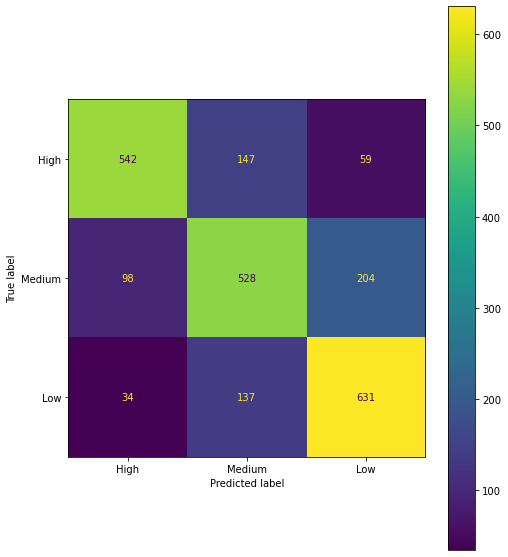

In [51]:
plot_confusion_matrix(grid, X_test, y_test, labels=["High","Medium", "Low"])

In [52]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

        High       0.80      0.72      0.76       748
         Low       0.71      0.79      0.74       802
      Medium       0.65      0.64      0.64       830

    accuracy                           0.71      2380
   macro avg       0.72      0.72      0.72      2380
weighted avg       0.72      0.71      0.71      2380



# SGD Classifier

Train SGD Classifier

In [53]:
sgd = SGDClassifier(early_stopping=True,penalty = "elasticnet")
scaler=StandardScaler()
pipe =  Pipeline(steps=[('imp', imputer), ('scaler', scaler),('sgd', sgd)])
param_grid_sgd = {'sgd__alpha': 10.**np.arange(-5, 1),'sgd__max_iter': [10,100,1000]}
grid = GridSearchCV(pipe, param_grid = param_grid_sgd  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))

0.5984869711403754
best mean cross-validation score: 0.599


In [54]:
a = grid.best_estimator_.get_params()
for key, value in a.items():
    print(key, ' : ', value)

memory  :  None
steps  :  [('imp', KNNImputer()), ('scaler', StandardScaler()), ('sgd', SGDClassifier(alpha=0.001, early_stopping=True, max_iter=100,
              penalty='elasticnet'))]
verbose  :  False
imp  :  KNNImputer()
scaler  :  StandardScaler()
sgd  :  SGDClassifier(alpha=0.001, early_stopping=True, max_iter=100,
              penalty='elasticnet')
imp__add_indicator  :  False
imp__copy  :  True
imp__metric  :  nan_euclidean
imp__missing_values  :  nan
imp__n_neighbors  :  5
imp__weights  :  uniform
scaler__copy  :  True
scaler__with_mean  :  True
scaler__with_std  :  True
sgd__alpha  :  0.001
sgd__average  :  False
sgd__class_weight  :  None
sgd__early_stopping  :  True
sgd__epsilon  :  0.1
sgd__eta0  :  0.0
sgd__fit_intercept  :  True
sgd__l1_ratio  :  0.15
sgd__learning_rate  :  optimal
sgd__loss  :  hinge
sgd__max_iter  :  100
sgd__n_iter_no_change  :  5
sgd__n_jobs  :  None
sgd__penalty  :  elasticnet
sgd__power_t  :  0.5
sgd__random_state  :  None
sgd__shuffle  :  True


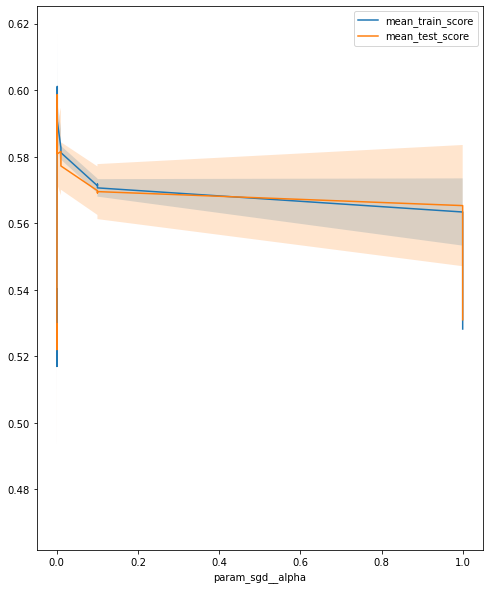

In [55]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_sgd__alpha', 'mean_train_score')
results.plot('param_sgd__alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_sgd__alpha.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_sgd__alpha.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

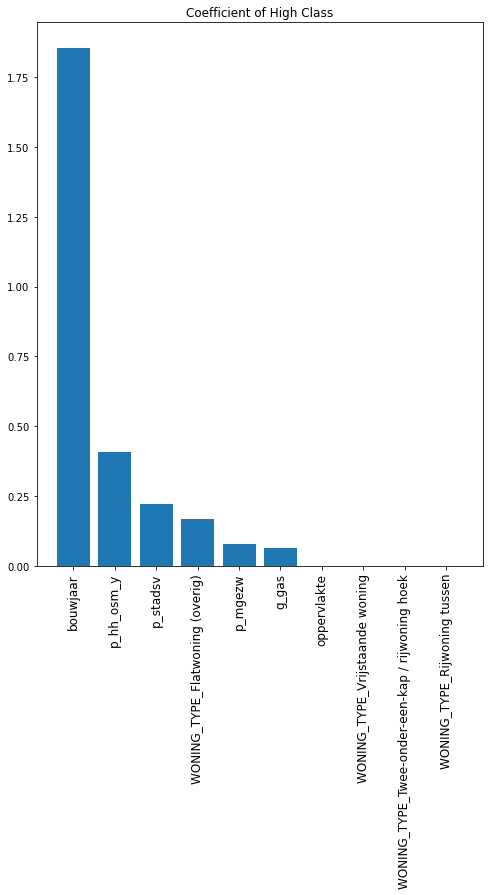

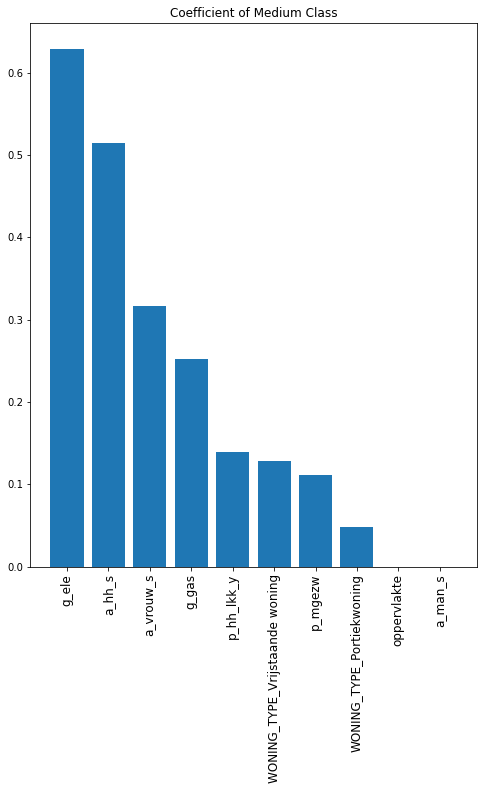

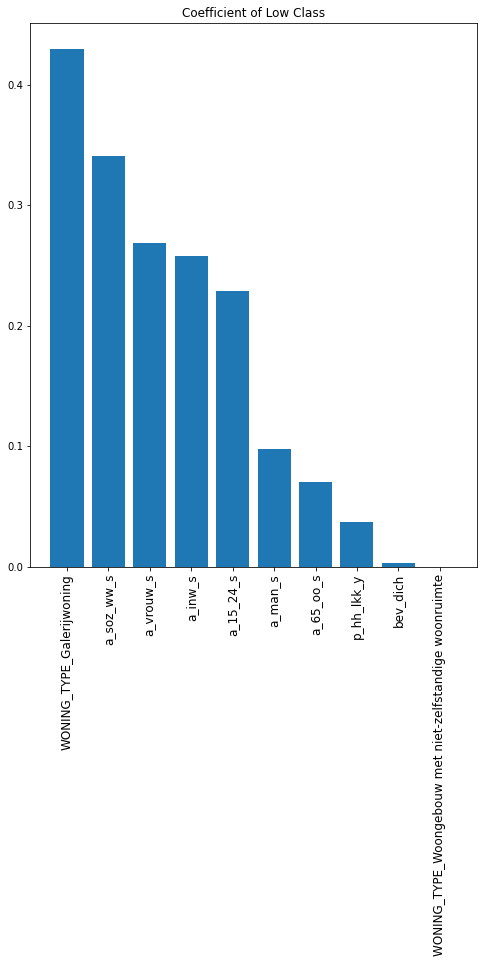

In [56]:
feature_imp = grid.best_estimator_.named_steps['sgd'].coef_
df_feature = pd.DataFrame(np.transpose(feature_imp),X_train.columns,columns=["feature_coef_high","feature_coef_medium",'feature_coef_low'])
df_feature1 = df_feature.sort_values(by="feature_coef_high" , ascending=False)
df_feature1 = df_feature1[:10]
df_feature2 = df_feature.sort_values(by="feature_coef_medium" , ascending=False)
df_feature2 = df_feature2[:10]
df_feature3 = df_feature.sort_values(by="feature_coef_low" , ascending=False)
df_feature3 = df_feature3[:10]
plt.bar(df_feature1.index, df_feature1.feature_coef_high, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.title('Coefficient of High Class')
plt.show()

plt.bar(df_feature2.index, df_feature2.feature_coef_medium, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.title('Coefficient of Medium Class')
plt.show()

plt.bar(df_feature3.index, df_feature3.feature_coef_low, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.title('Coefficient of Low Class')
plt.show()  

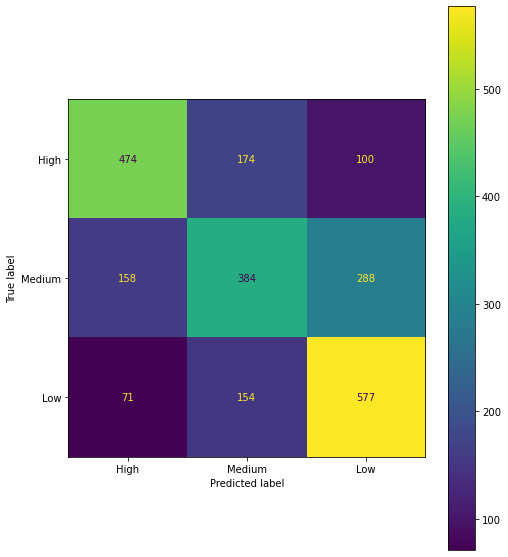

In [57]:
plot_confusion_matrix(grid, X_test, y_test, labels=["High","Medium", "Low"])

In [58]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

        High       0.67      0.63      0.65       748
         Low       0.60      0.72      0.65       802
      Medium       0.54      0.46      0.50       830

    accuracy                           0.60      2380
   macro avg       0.60      0.61      0.60      2380
weighted avg       0.60      0.60      0.60      2380



# Train best model on the full dataset

In [62]:
sample_used = 1
rus = RandomUnderSampler(replacement=False, random_state=42)
X_rus, y_rus = rus.fit_resample(X, y_cat)
X_train, X_test, y_train, y_test = train_test_split(
    X_rus, y_rus, random_state=42, train_size=sample_used*0.75, test_size = sample_used*0.25)

In [63]:
xgb = XGBClassifier()
pipe =  Pipeline(steps=[('imp', imputer), ('xgb', xgb)])
param_grid = {'xgb__max_depth': [8], 'xgb__learning_rate': [0.1], 'xgb__gamma': [0.0], 'xgb__n_estimators': [100]}
grid = GridSearchCV(pipe, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_depth:', grid.best_estimator_.get_params()['xgb__max_depth'])
print('Best learning_rate:', grid.best_estimator_.get_params()['xgb__learning_rate'])
print('Best gamma:', grid.best_estimator_.get_params()['xgb__gamma'])
print('Best n_estimators:', grid.best_estimator_.get_params()['xgb__n_estimators'])

C:\Users\simon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7902703838610255
best mean cross-validation score: 0.765
Best max_depth: 8
Best learning_rate: 0.1
Best gamma: 0.0
Best n_estimators: 100


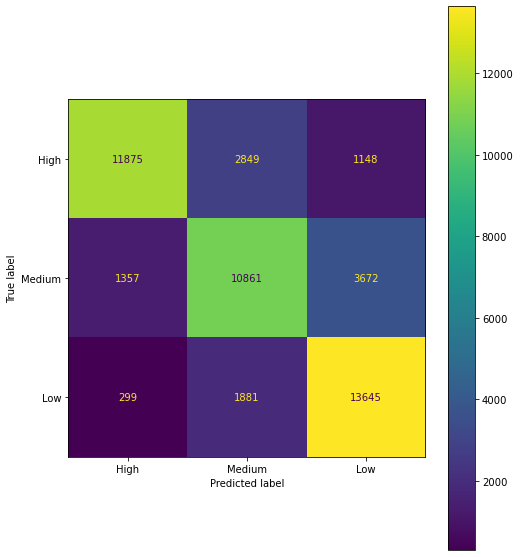

In [64]:
plot_confusion_matrix(grid, X_test, y_test, labels=["High","Medium", "Low"])

In [65]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

        High       0.88      0.75      0.81     15872
         Low       0.74      0.86      0.80     15825
      Medium       0.70      0.68      0.69     15890

    accuracy                           0.76     47587
   macro avg       0.77      0.76      0.76     47587
weighted avg       0.77      0.76      0.76     47587



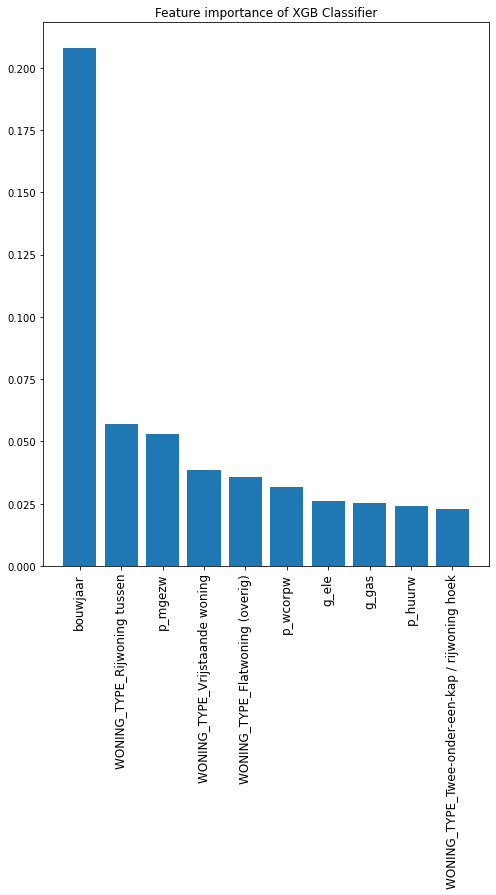

In [67]:
#plot the most important features
feature_imp = grid.best_estimator_.named_steps['xgb'].feature_importances_
df_feature = pd.DataFrame(feature_imp,X_train.columns,["feature_importance"])
df_feature = df_feature.sort_values(by="feature_importance" , ascending=False)
df_feature = df_feature[:10]
plt.bar(df_feature.index, df_feature.feature_importance, orientation = 'vertical')
plt.tick_params( axis="x", labelsize=12, labelrotation=90)
plt.title('Feature importance of XGB Classifier')
plt.show()